# <font color='green'>**Hopfield Neural Network on Class-Teacher Problem**</font>

---

by Chakrit, Pimpunyawat, Rapeepan

September 2024

---



---


---


The basic concept is the following


---


**Set up**

The states are labeled by $u_{ijk}$ where $i$ indicates the class $i^{\rm th}$, $j$ indicates the teacher $j^{\rm th}$ and $k$ indicates the period $k^{\rm th}$

The activation function is discrete, i.e., $v_{ijk} = g(u_{ijk})$ where
$v_{ijk} = 0$ when $u_{ijk} \leq 0$ and $v_{ijk} = 1$ when $u_{ijk} > 0$

The energy function is written in terms of the activation output + external output with a weighted matrix as follow:

$E = -\frac{1}{2}\sum\limits_{i,j,k,i',j',k'} W_{i'j'k'ijk}v_{i'j'k'}v_{ijk} - \sum\limits_{ijk}I_{ijk}v_{ijk}$



---
**Weight and Input**

From the energy term:

$E = \frac{\alpha}{2}\sum\limits_i^C \sum\limits_j^T \left(\sum\limits_k^P v_{ijk} - R_{ij}\right)^2 + \frac{\beta}{2}\sum\limits_i^C \sum\limits_j^T \sum\limits_k^P \sum\limits_{j'\neq j}^T v_{ijk} v_{ij'k} + \frac{\gamma}{2}\sum\limits_i^C \sum\limits_j^T \sum\limits_k^P \sum\limits_{i'\neq i}^C v_{ijk} v_{i'jk}$

The weight and input can be written by

$W_{i'j'k'ijk} = -\alpha \delta_{ii'}\delta_{jj'} - \beta \delta_{ii'} \left( 1 - \delta_{jj'}\right) \delta_{kk'} - \gamma \left( 1 - \delta_{ii'}\right) \delta_{jj'} \delta_{kk'}$

$I_{ijk} = \alpha R_{ij}$



---


**Update**

The time step is labeled by $t$ and the states are updated using the Adam method

We initialize the first moment $m_0$ and second moment $v_0$ to zero:

$m_0 = 0, \quad v_0 = 0$

At each time step $t$, we compute the gradient $g_t$ of the loss function (or energy) with respect to the model parameters $\theta_t$:

$g_t = -\left( \sum\limits_{i'j'k'} W_{i'j'k'ijk} v_{i'j'k'} + I_{ijk} \right)$

The first moment $m_t$ is updated using an exponential decay of past gradients:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

where $\beta_1 \in [0, 1)$ is the decay rate of the first moment. Typically, $\beta_1 = 0.9$.

The second moment $v_t$, which tracks the variance of the gradients, is updated as follows:

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$

where $\beta_2 \in [0, 1)$ is the decay rate of the second moment, often set to $\beta_2 = 0.999$.

To correct for initialization bias, we compute the bias-corrected first and second moments:

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

Finally, the parameters $\theta$ are updated:

$u_{ijk}(t+1) = u_{ijk}(t) + \frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

where $\eta$ is the learning rate, and $\epsilon$ is a small constant (usually $1 \times 10^{-8}$) to prevent division by zero.

$v_{ijk}(t+1) = g(u(t))$

Then keep doing this until the energy converges to the minimum.

or

Tabu Search

or

Genetic Algorithm


---

**Constraints**

The constraints are the following:

$\sum\limits_{k=1}^{P} v_{ijk} = R_{ij}$: The requirement from school that for the j$^{\rm th}$ teacher should teach $R_{ij}$ times for the i$^{\rm th}$ class.

$\sum\limits_{j=1}^{T} v_{ijk} \leq 1$: The requirement that no 2 teachers teach the same class at the same time.

$\sum\limits_{i=1}^{C} v_{ijk} \leq 1$: The requirement that no 2 classes were taught by the same teacher at the same time.

In [31]:
import numpy as np
from functools import lru_cache
import time

In [51]:
def RequirementMatrix(num_teacher,num_class,num_classperteacher):
    """ Rewrite the requirement matrix and input for a more equal distributed responsibility for every teacher """
    num_arrays = num_teacher
    array_length = num_class
    constant_sum = num_classperteacher
    # Create an empty tensor with the desired shape
    tensor_shape = (num_arrays, array_length)
    tensor = np.empty(tensor_shape)
    # Generate random arrays with sum equal to constant_sum and store them in the tensor
    for i in range(num_arrays):
        # Generate random integer values for the array
        random_values = np.random.randint(1, constant_sum, size=(array_length,))
        # Compute the scaling factor
        scaling_factor = constant_sum / np.sum(random_values)
        # Scale the values to sum to constant_sum
        scaled_values = np.multiply(random_values, scaling_factor)
        # Round the values to the nearest integer
        rounded_values = np.round(scaled_values)
        # Adjust the last element of the array to ensure the sum is exactly equal to constant_sum
        rounded_values[-1] = constant_sum - np.sum(rounded_values[:-1])
        # Store the resulting tensor in the main tensor object
        tensor[i] = rounded_values
    #self.R = np.transpose(tensor)
    #self.I = self.alpha*np.einsum('ij,k->ijk',self.R,self.one_k)
    return(np.transpose(tensor))

In [52]:
class HopfieldCT:
    """ Class for Hopfield Neural Network for Class-Teacher Problem"""

    def __init__(self,num_teacher,num_class,num_period,R_input,alpha:float,beta:float,gamma:float,lr = 0.01, beta1 = 0.9, beta2 = 0.999):
        """ initialize """
        self.T = num_teacher
        self.C = num_class
        self.P = num_period
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.constraint_tag = 0
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-8
        ##### Weight initialization #####
        self.delta_ii = np.eye(self.C)
        self.delta_jj = np.eye(self.T)
        self.delta_kk = np.eye(self.P)
        self.one_kk = np.ones((self.P,self.P))
        self.one_k = np.ones(self.P)
        self.W = -self.alpha*np.einsum('il,jm,kn->ijklmn',self.delta_ii,self.delta_jj,self.one_kk) - self.beta*np.einsum('il,jm,kn->ijklmn',self.delta_ii,1-self.delta_jj,self.delta_kk) - self.gamma*np.einsum('il,jm,kn->ijklmn',1-self.delta_ii,self.delta_jj,self.delta_kk)
        ##### External input ######
        self.R = R_input
        self.I = self.alpha*np.einsum('ij,k->ijk',self.R,self.one_k)
        ##### Neuron state (random for initial values) #####
        self.u = np.random.rand(self.C,self.T,self.P)
        ##### Activation level (random for initial values) #####
        self.v = np.zeros((self.C,self.T,self.P))
        ##### Adam variables (moments) #####
        self.v_adam = np.zeros((self.C,self.T,self.P))
        self.m_adam = np.zeros((self.C,self.T,self.P))
        self.t = 0
        
    def resetstate(self):
        self.constraint_tag = 0
        self.u = np.random.rand(self.C,self.T,self.P)
        self.v = np.zeros((self.C,self.T,self.P))
        self.v_adam = np.zeros((self.C,self.T,self.P))
        self.m_adam = np.zeros((self.C,self.T,self.P))
        self.t = 0
        
    @lru_cache(maxsize=None)
    def Energy(self,v_tuple):
        """ Calculate the energy """
        v_temp = np.array(v_tuple).reshape(self.C,self.T,self.P)
        self.E = -1/2*np.einsum('ijk,ijklmn,lmn',v_temp,self.W,v_temp) - np.einsum('ijk,ijk',self.I,v_temp)
        return(self.E)

    def ActivationOutput(self,u_temp):
        """ Calculate the activation output """
        return(np.heaviside(u_temp,np.zeros((self.C,self.T,self.P))))

    def UpdateState(self,u_temp,v_temp):
        """ Update the state of neuron for the next step with Adam method """
        grad = np.einsum('ijklmn,ijk->lmn',self.W,v_temp) + self.I
        self.t += 1
        self.m_adam = self.beta1 * self.m_adam + (1 - self.beta1) * grad
        self.v_adam = self.beta2 * self.v_adam + (1 - self.beta2) * grad**2
        m_hat = self.m_adam / (1 - self.beta1 ** self.t)
        v_hat = self.v_adam / (1 - self.beta2 ** self.t)
        return(u_temp + self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon))
    
    def Check(self):
        sumI =  np.sum(self.v , 0)  # Sum over all classes
        sumJ  =  np.sum(self.v , 1) # Sum over all teachers
        sumK =  np.sum(self.v , 2) # Sum over all periods
        checkColumn = np.less_equal(sumI,np.ones((self.T,self.P))) # The requirement that no 2 classes were taught by the same teacher at the same time.
        checkrow = np.less_equal(sumJ,np.ones((self.C,self.P))) # The requirement that no 2 teachers teach the same class at the same time.
        checkK = np.equal(sumK,self.R) # The requirement from school that for the jth teacher should teach 𝑅𝑖𝑗 times for the ith class.
        if(np.all(checkColumn) == True and np.all(checkrow) == True and np.all(checkK) == True ):
            print('*******************************************************\n')
            print('*******************  All is pass  *********************\n')
            print('*******************************************************\n')
            print('Comparing constraints (R)\n',checkK)
            print('Rij: ',self.R)
            print('Sum k: ',sumK)
            print('Sum i: ',sumI)
            print('Sum j: ',sumJ)
            print('The solution is:')
            print('v = ',self.v)
            self.constraint_tag = 1

    def AdamOptimizer(self, num_steps: int):
        self.resetstate()
        energy_history = []
        best_energy = float('inf')
        best_solution = None
        self.v = self.ActivationOutput(self.u) # fist time activation
        for step in range(num_steps):
            E1 = self.Energy(tuple(self.v.flatten()))
            u_temp = self.UpdateState(self.u, self.v)
            v_temp = self.ActivationOutput(u_temp)
            E2 = self.Energy(tuple(v_temp.flatten()))
            energy_history.append(E2)
            
            if E2 < best_energy:
                best_energy = E2
                best_solution = u_temp
            
            if E2 - E1 <= 0:
                self.u = u_temp
                self.v = v_temp
                
            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-10):
                self.Check()
                if(self.constraint_tag == 1):
                    break
        
        return energy_history, best_solution, best_energy

    def TabuSearch(self, num_steps: int, tabu_size=5):
        
        self.resetstate()
        self.v = self.ActivationOutput(self.u)  # Initial activation
        current_u = self.u
        current_energy = self.Energy(tuple(self.v.flatten()))  # Calculate initial energy
        best_u = current_u
        best_energy = current_energy
        tabu_list = []

        energy_history = [current_energy]

        for step in range(num_steps):
            # Generate neighbors (small random perturbations)
            neighbors = [current_u + np.random.normal(0, 0.1, size=self.u.shape) for _ in range(10)]

            # Evaluate the energy of each neighbor
            neighbor_energies = [self.Energy(tuple(self.ActivationOutput(neighbor).flatten())) for neighbor in neighbors]

            # Select the best neighbor that is not in the tabu list
            best_neighbor = None
            best_neighbor_energy = float('inf')
            for neighbor, energy in zip(neighbors, neighbor_energies):
                
                is_in_tabu = any(np.array_equal(neighbor, tabu_u) for tabu_u in tabu_list)
                
                if energy < best_neighbor_energy and not is_in_tabu:
                    best_neighbor = neighbor
                    best_neighbor_energy = energy

            # Move to the best neighbor and update the tabu list
            current_u = best_neighbor
            current_energy = best_neighbor_energy
            self.u = current_u
            self.v = self.ActivationOutput(current_u)

            # Add current_u to the tabu list and maintain the tabu list size
            tabu_list.append(current_u)
            if len(tabu_list) > tabu_size:
                tabu_list.pop(0)  # Remove the oldest entry

            # Track the best solution found so far
            if current_energy < best_energy:
                best_u = current_u
                best_energy = current_energy

            energy_history.append(current_energy)

            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-10):
                self.v = self.ActivationOutput(best_u)
                self.Check()
                if(self.constraint_tag == 1):
                    break

        return energy_history, best_u, best_energy

    def GeneticAlgorithm(self, num_steps: int, population_size=100, mutation_rate=0.8):
      
        # Initialize population
        population = [np.random.rand(*self.u.shape) for _ in range(population_size)]

        # Evaluate initial population
        energies = [self.Energy(tuple(self.ActivationOutput(individual).flatten())) for individual in population]

        energy_history = [min(energies)]
        best_individual = population[np.argmin(energies)]
        best_energy = min(energies)

        for step in range(num_steps):
            # Select the best individuals for crossover (elitism)
            sorted_indices = np.argsort(energies)
            selected_population = [population[i] for i in sorted_indices[:population_size//2]]

            # Crossover: Generate new individuals by combining the top individuals
            new_population = []
            for i in range(0, len(selected_population), 2):
                parent1 = selected_population[i]
                parent2 = selected_population[i + 1 if i + 1 < len(selected_population) else 0]
                crossover_point = np.random.randint(self.u.size)  # Single-point crossover
                child1 = np.concatenate((parent1.flatten()[:crossover_point], parent2.flatten()[crossover_point:])).reshape(self.u.shape)
                child2 = np.concatenate((parent2.flatten()[:crossover_point], parent1.flatten()[crossover_point:])).reshape(self.u.shape)
                new_population.append(child1)
                new_population.append(child2)

            # Mutation: Randomly mutate some individuals
            for individual in new_population:
                if np.random.rand() < mutation_rate:
                    mutation = np.random.normal(0, 0.1, size=self.u.shape)
                    individual += mutation

            # Evaluate the new population
            population = selected_population + new_population
            energies = [self.Energy(tuple(self.ActivationOutput(individual).flatten())) for individual in population]

            # Track the best individual
            current_best_energy = min(energies)
            if current_best_energy < best_energy:
                best_individual = population[np.argmin(energies)]
                best_energy = current_best_energy

            energy_history.append(current_best_energy)

            # Early exit if the energy does not improve for several iterations
            if step > 10 and np.all(np.abs(np.diff(energy_history[-10:])) < 1e-10):
                self.v = self.ActivationOutput(best_individual)
                self.Check()
                if(self.constraint_tag == 1):
                    break

        return energy_history, best_individual, best_energy


In [60]:
num_teacher = 5
num_class = 5
num_teacherperclass = 3
num_period = 6
R = RequirementMatrix(num_teacher, num_class, num_teacherperclass)
while (R < 0).any():
    R = RequirementMatrix(num_teacher, num_class, num_teacherperclass)

In [61]:
R

array([[0., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1.],
       [1., 1., 2., 0., 2.]])

In [62]:
HNN = HopfieldCT(num_teacher, num_class, num_period, R, alpha=1, beta=1, gamma=1)

*******************************************************

*******************  All is pass  *********************

*******************************************************

Comparing constraints (R)
 [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
Rij:  [[0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 1. 2. 0. 2.]]
Sum k:  [[0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 1. 2. 0. 2.]]
Sum i:  [[0. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0.]]
Sum j:  [[1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]
The solution is:
v =  [[[0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 

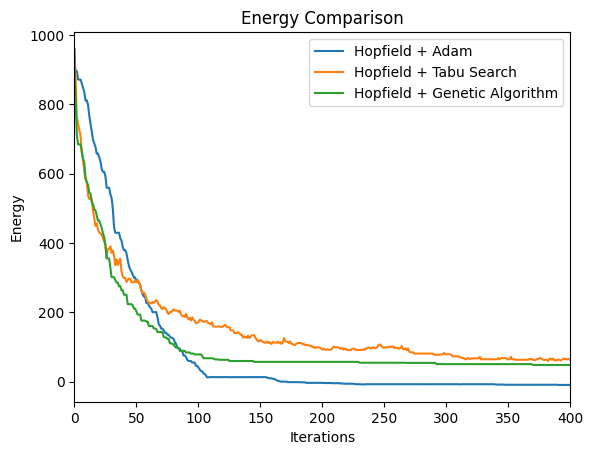

In [63]:
# Run Hopfield Neural Network optimization

# Run Adam
start = time.time()
adam_energy_history, adam_best_solution, adam_best_energy = HNN.AdamOptimizer(num_steps=1000)
end = time.time()
print(f"Adam took {end - start} seconds")

# Run Tabu Search
start = time.time()
tabu_energy_history, tabu_best_solution, tabu_best_energy = HNN.TabuSearch(num_steps=1000)
end = time.time()
print(f"Tabu took {end - start} seconds")

# Run Genetic Algorithm
start = time.time()
ga_energy_history, ga_best_solution, ga_best_energy = HNN.GeneticAlgorithm(num_steps=1000)
end = time.time()
print(f"GA took {end - start} seconds")

# Plot the energy histories to compare performance
import matplotlib.pyplot as plt

plt.plot(adam_energy_history, label='Hopfield + Adam')
plt.plot(tabu_energy_history, label='Hopfield + Tabu Search')
plt.plot(ga_energy_history, label='Hopfield + Genetic Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.title('Energy Comparison')
plt.xlim(0,min(len(adam_energy_history),len(tabu_energy_history),len(ga_energy_history)))
plt.legend()
plt.show()


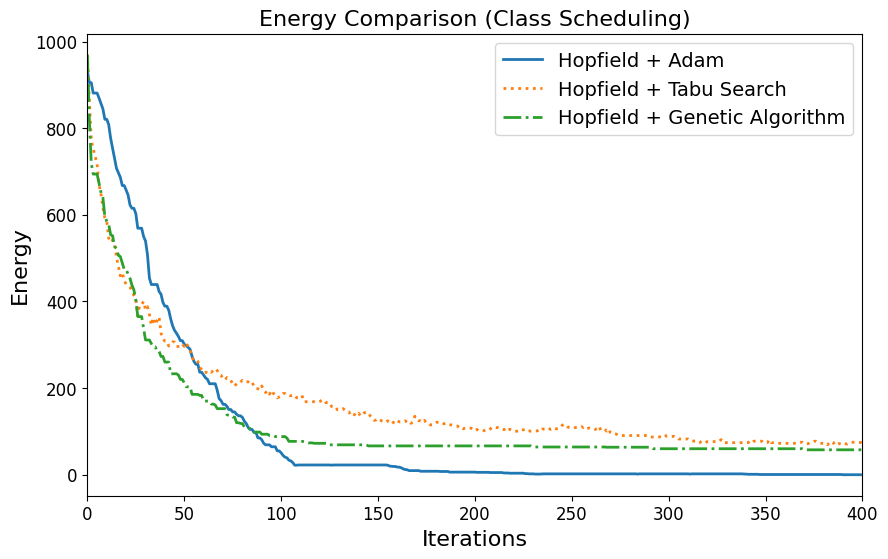

In [64]:
plt.figure(figsize=(10, 6))
Emin = adam_best_energy
t = min(len(adam_energy_history),len(tabu_energy_history),len(ga_energy_history))
plt.plot(adam_energy_history - Emin, label='Hopfield + Adam',linewidth=2)
plt.plot(tabu_energy_history - Emin, label='Hopfield + Tabu Search',linewidth=2,linestyle=':')
plt.plot(ga_energy_history - Emin, label='Hopfield + Genetic Algorithm',linewidth=2,linestyle='-.')
plt.xlabel('Iterations',fontsize=16)
plt.ylabel('Energy',fontsize=16)
plt.title('Energy Comparison (Class Scheduling)',fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,t)
# plt.yscale('log')
# plt.savefig('energy_comparison_HopfieldCT.png', dpi=600, bbox_inches='tight')
# plt.savefig('energy_comparison_HopfieldCT_log.png', dpi=600, bbox_inches='tight')

plt.show()